# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# Загрузим всё необходимое
import numpy as np
import pandas as pd
import torch
import transformers
import re

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer

from sklearn.metrics import f1_score
import time

from tqdm import notebook
from tqdm import tqdm


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cropp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cropp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cropp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\cropp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# загрузим данные
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('toxic_comments.csv')

In [3]:
# проверим данные на всякое нехорошее. использую функцию, которой пользовался в прошлых проектах
names= [df]

def info_func(names):
    for name in names:
        df_temp = pd.DataFrame(name)
        display(df_temp.head(10))
        display(df_temp.info())
        display('Кол-во дублей:', df_temp.duplicated().sum())
        display('Кол-во НАНов:', df_temp.isna().sum())
    return
info_func(names)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

'Кол-во дублей:'

0

'Кол-во НАНов:'

text     0
toxic    0
dtype: int64

Никакого криминала, кроме обсценной лексики на данном этапе не обнаружено. Но текстам, в любом случае нужна предобработка

Поступим следующим образом:
* Очистим текст от стоп-слов и ненужных символов, приведём к нижнему регистру
* Лематизируем тексты
* Проведём токенезацию и векторизацию текстов
* Обучим модели и посмотрим что там с поиском мамкиных токсиков


### Предобработка текста 

In [4]:
# проведём лематизацию
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

In [5]:
# убираем всё лишнее
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z ]', ' ', text).split()
    clear_text = ' '.join(clear_text)
    return(clear_text)
tqdm.pandas()
df['text'] = df['text'].progress_apply(clear_text)
df['text'] = df['text'].str.lower()
df.head()

100%|███████████████████████████████████████████████████████████████████████| 159571/159571 [00:01<00:00, 87192.97it/s]


,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0


In [6]:
corpus = df['text'].values.astype('U')
corpus_lemm = [lemmatize(clear_text(corpus[i])) for i in range(len(corpus))]
stopwords = set(nltk_stopwords.words('english'))

0    0.898321
1    0.101679
Name: toxic, dtype: float64


<AxesSubplot:>

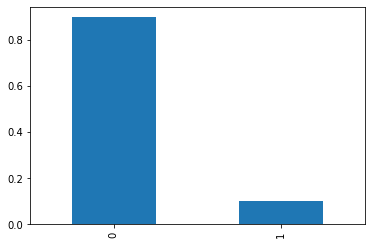

In [7]:
# проверим на дисбаланс
class_frequency = df['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Дисбаланс, что ожидаемо, присутствует. Поправим положении с помощью гиперпараметров при подборе модели

Разделим нашу выборку на тестовую и обучающую

In [8]:
features_train, features_test, target_train, target_test = train_test_split(corpus_lemm, df['toxic'], 
                                                    test_size=0.2,
                                                    random_state=12345)

In [9]:
# Проведём векторизацию корпусов с помощью TfidfVectorizer, заодно удалим стоп-слова
tf_idf_vec = TfidfVectorizer(ngram_range=(1,1), stop_words=stopwords,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1)

features_train_vec = tf_idf_vec.fit_transform(features_train)
features_test_vec = tf_idf_vec.transform(features_test)
print(f"Размер тренировочного датасета: {features_train_vec.shape}")
print(f"Размер тренировочного датасета: {features_test_vec.shape}")

Размер тренировочного датасета: (127656, 40036)
Размер тренировочного датасета: (31915, 40036)


На этом подготовительный этап можно считать законченным. Приступаем к обучению

## Обучение

### Логистическая регрессия

* Обучение, подбор гиперпараметров, кросс-валидацию проведём с помощью GridSearchCV библиотеки sklearn
* Попробуем подобрать лучший параметр регуляризации C
* Посмотрим, влияет ли балансировка классов на F1

In [10]:
'''lr = LogisticRegression()
lr_params = {'C': np.linspace(10, 20, num = 11, endpoint = True),
             'max_iter': [1000], 'class_weight':['balanced', None]}

lr_grid = GridSearchCV(lr, lr_params,
                  cv=5,
                  scoring='f1',
                  n_jobs=-1,
                  verbose=2)
lr_grid.fit(features_train_vec, target_train)
print(f"Наилучший показатель f1: {lr_grid.best_score_:.3f}")
print(f"При параметре регуляризации и балансировки для лучшей модели: {lr_grid.best_params_}'''

'lr = LogisticRegression()\nlr_params = {\'C\': np.linspace(10, 20, num = 11, endpoint = True),\n             \'max_iter\': [1000], \'class_weight\':[\'balanced\', None]}\n\nlr_grid = GridSearchCV(lr, lr_params,\n                  cv=5,\n                  scoring=\'f1\',\n                  n_jobs=-1,\n                  verbose=2)\nlr_grid.fit(features_train_vec, target_train)\nprint(f"Наилучший показатель f1: {lr_grid.best_score_:.3f}")\nprint(f"При параметре регуляризации и балансировки для лучшей модели: {lr_grid.best_params_}'

In [11]:
print(f"Наилучший показатель f1: 0.774")
print(f"При параметре регуляризации и балансировки для лучшей модели: 'C': 12.0, 'class_weight': None, 'max_iter': 1000")

Наилучший показатель f1: 0.774
При параметре регуляризации и балансировки для лучшей модели: 'C': 12.0, 'class_weight': None, 'max_iter': 1000


### CatBoost

Для котёнкиного бустинга сделаем свой скорер. При использовании GridSearch есть 2 пути: страдать несколько дней и подбирать на CPU или получить ошибку переполнения памяти от CUDA фреймворка при использовании GPU. Принято решение считать на GPU, а гиперпараметры подобрать с помощью удачи

In [12]:
def scoring(model):
    predicted_test = model.predict(features_test_vec)
    test_f1 = f1_score(target_test, predicted_test)
    return test_f1

In [13]:
'''cb = CatBoostClassifier(random_state=12345, task_type="GPU", l2_leaf_reg=50, learning_rate=0.01, iterations=5000, scale_pos_weight=9)
cb.fit(features_train_vec, target_train)
print(f"Оценка f1:", scoring(cb))'''

'cb = CatBoostClassifier(random_state=12345, task_type="GPU", l2_leaf_reg=50, learning_rate=0.01, iterations=5000, scale_pos_weight=9)\ncb.fit(features_train_vec, target_train)\nprint(f"Оценка f1:", scoring(cb))'

In [14]:
print(f"Оценка f1:", 0.7322)

Оценка f1: 0.7322


### LGBM

In [15]:
'''lgbm = LGBMClassifier(random_state=12345)
lgbm_params = {'n_estimators': [600, 100, 700],
              'num_leaves': [91, 31, 120], 
              'learning_rate':[0.05, .01, 0.07]}
lgbm_grid = GridSearchCV(lgbm, lgbm_params,
                         cv=5, n_jobs=-1, verbose=5, scoring='f1')
lgbm_grid.fit(features_train_vec, target_train)

print(f"Наилучший показатель f1: {lgbm_grid.best_score_:.3f}")
print('Лучшие параметры LGBM', lgbm_grid.best_params_)'''
print('Наилучший показатель f1:', 0.775)
print('Лучшие параметры LGBM', 'learning_rate: 0.05, n_estimators: 600, num_leaves: 91')

Наилучший показатель f1: 0.775
Лучшие параметры LGBM learning_rate: 0.05, n_estimators: 600, num_leaves: 91


В неравной борьбе побеждает LGBM, т.к. к логрегу могут быть вопросы, хотя она самая быстрая. LGBM хоть и медленная как черепаха, но не бесполезная. Посмотрим какие результаты она даст на тестовой выборке.

## Тесты

CatBoost уже проверен на тестовых данных, поэтому здесь протестим LGBM, как модель с лучшей метрикой на обучающей выборке

In [16]:
lgbm_test = LGBMClassifier(random_state=12345, learning_rate=0.05, n_estimators=600, num_leaves=91)
lgbm_test.fit(features_train_vec, target_train)
predicted_test = lgbm_test.predict(features_test_vec)
test_f1 = f1_score(target_test, predicted_test)
print('f1:', test_f1)

f1: 0.777209143636984


Результаты вполне удовлетворительные. Аж на 0.027 превышают пороговое значение. Можно считать, что мы научились достаточно точно выслеживать хейтеров в твиттере

## Выводы

По итогу работы можно сделать следующие выводы:
* Обучать модели для анализа текстов - не так-то просто и очень трудоёмко/ресурсоёмко (билд LGBM для CUDA не даёт прироста производительности в случае с данным датасетом. CatBoost на GPU работает достойно, но крашит GridSearchCV)
* Рассмотренные модели сопоставимы по качеству предсказаний, однако очень различаются по быстродействию. LGBM номинально даёт лучший результат на обучающей выборке, но медленная, а логрег быстрая, но даёт худшие результаты номинально